# PID Classification with Neural Networks (Supervised Training)

This example illustrates the classification of particle types using [tensorflow](https://www.tensorflow.org/)/[keras](https://keras.io/) neural networks. The supervised training is based on a Multilayer Perceptron (MLP) with labeled MC generated data of [BaBar](https://www.flickr.com/photos/slaclab/46211844232).

We begin with the standard imports. This notebook uses numpy, pandas, seaborn, matplotlib, and tensorflow/keras. The data are read from a ROOT file with uproot:

In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals

import pathlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import uproot
from sklearn.metrics import classification_report, confusion_matrix

print(tf.__version__)

1.13.1


# Training Dataset
We are reading the training dataset from a ROOT file. The file contains particle momentum (mom) and track elevation (theta), dE/dx measurement from silicon vertex tracker (svt) and drift chamber (dch), as well as energy deposit in the electromagnetic calorimeter (emc), the cerenkov angle in the DIRC (drc), and the hit patterns in the instrumented flux return (ifr). The file in addition holds higher level features like partial energy sums, zernicke momenta, likelihood etc. 

The particles are labeled (id)
* Electron = 0
* Muon = 1
* Pion = 2
* Kaon = 3
* Proton = 4

In [2]:
target_names = ['Electron', 'Muon', 'Pion', 'Kaon', 'Proton']

In [3]:
file = uproot.open("pid.root")

In [4]:
file.keys()

[b'PidTuple;1']

In [5]:
tree = file["PidTuple"]
tree.keys()

[b'mom',
 b'theta',
 b'svt',
 b'emc',
 b'drc',
 b'dch',
 b'ifr',
 b'ifrExp',
 b'ifrAdd',
 b'ifrStrip',
 b'ifrFirst',
 b'ifrLast',
 b'emcS1S9',
 b'emcS9S25',
 b'emczern20',
 b'emczern40',
 b'emclat',
 b'charge',
 b'drcnphot',
 b'emcphi',
 b'emctheta',
 b'pid',
 b'lipisvt',
 b'limusvt',
 b'likasvt',
 b'lipidch',
 b'limudch',
 b'likadch',
 b'lipidrc',
 b'limudrc',
 b'likadrc',
 b'lipiemc',
 b'limuemc',
 b'likaemc',
 b'lipiifr',
 b'limuifr',
 b'likaifr',
 b'charge',
 b'id']

In [6]:
tree.numentries

83826

We assemble the training dataset as a pandas dataframe and plot the particle statistics:

In [7]:
data = tree.arrays(["id", "mom", "theta", "svt", "emc", "drc", "dch", "ifr"])
dataset = pd.DataFrame(data)
dataset.tail()

,b'id',b'mom',b'theta',b'svt',b'emc',b'drc',b'dch',b'ifr'
83821,4,1.156832,0.842868,5.810547,0.365639,0.495674,732.421875,0.000000
83822,4,2.320551,0.914929,4.296875,1.259613,0.749020,537.109375,0.000000
83823,4,1.881898,0.807030,4.589844,0.164413,0.710582,454.101562,2.352941
83824,4,1.998565,0.996907,3.564453,0.463104,0.721126,444.335938,3.019608
83825,4,0.995329,0.923367,6.005859,0.354385,0.364935,771.484375,0.000000


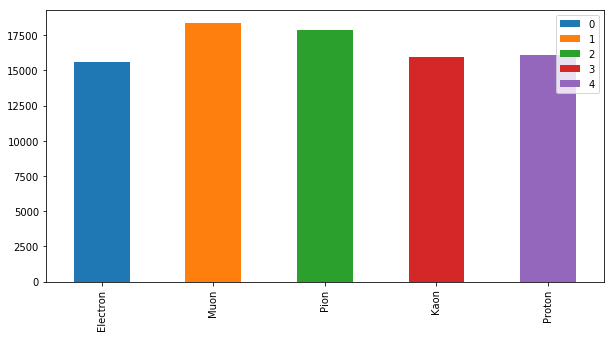

In [8]:
electron = dataset[dataset[b'id']==0][b'id'].value_counts()
muon = dataset[dataset[b'id']==1][b'id'].value_counts()
pion = dataset[dataset[b'id']==2][b'id'].value_counts()
kaon = dataset[dataset[b'id']==3][b'id'].value_counts()
proton = dataset[dataset[b'id']==4][b'id'].value_counts()

df = pd.DataFrame([electron, muon, pion, kaon, proton])
df.index = target_names
df.plot(kind='bar',stacked=True, figsize=(10,5))

# Data Preparation
We generate a training/validation dataset (90%) and a test dataset (10%) from the input dataset. The vectors are shuffled in random order.

In [9]:
train_dataset = dataset.sample(frac=0.9,random_state=0)
test_dataset = dataset.drop(train_dataset.index)
test_dataset.head()

,b'id',b'mom',b'theta',b'svt',b'emc',b'drc',b'dch',b'ifr'
10,0,2.273921,0.998170,3.466797,2.162170,0.824796,800.781250,0.000000
13,0,0.534659,0.896211,4.785156,0.465775,0.810391,576.171875,0.000000
21,0,1.164431,0.979493,3.369141,0.932312,0.823362,703.125000,0.588235
30,0,2.387105,0.621803,4.541016,0.000000,0.000000,0.000000,0.000000
43,0,2.244689,0.861318,4.248047,2.133179,0.823423,742.187500,0.000000


Show a correlation matrix of the feature vector:

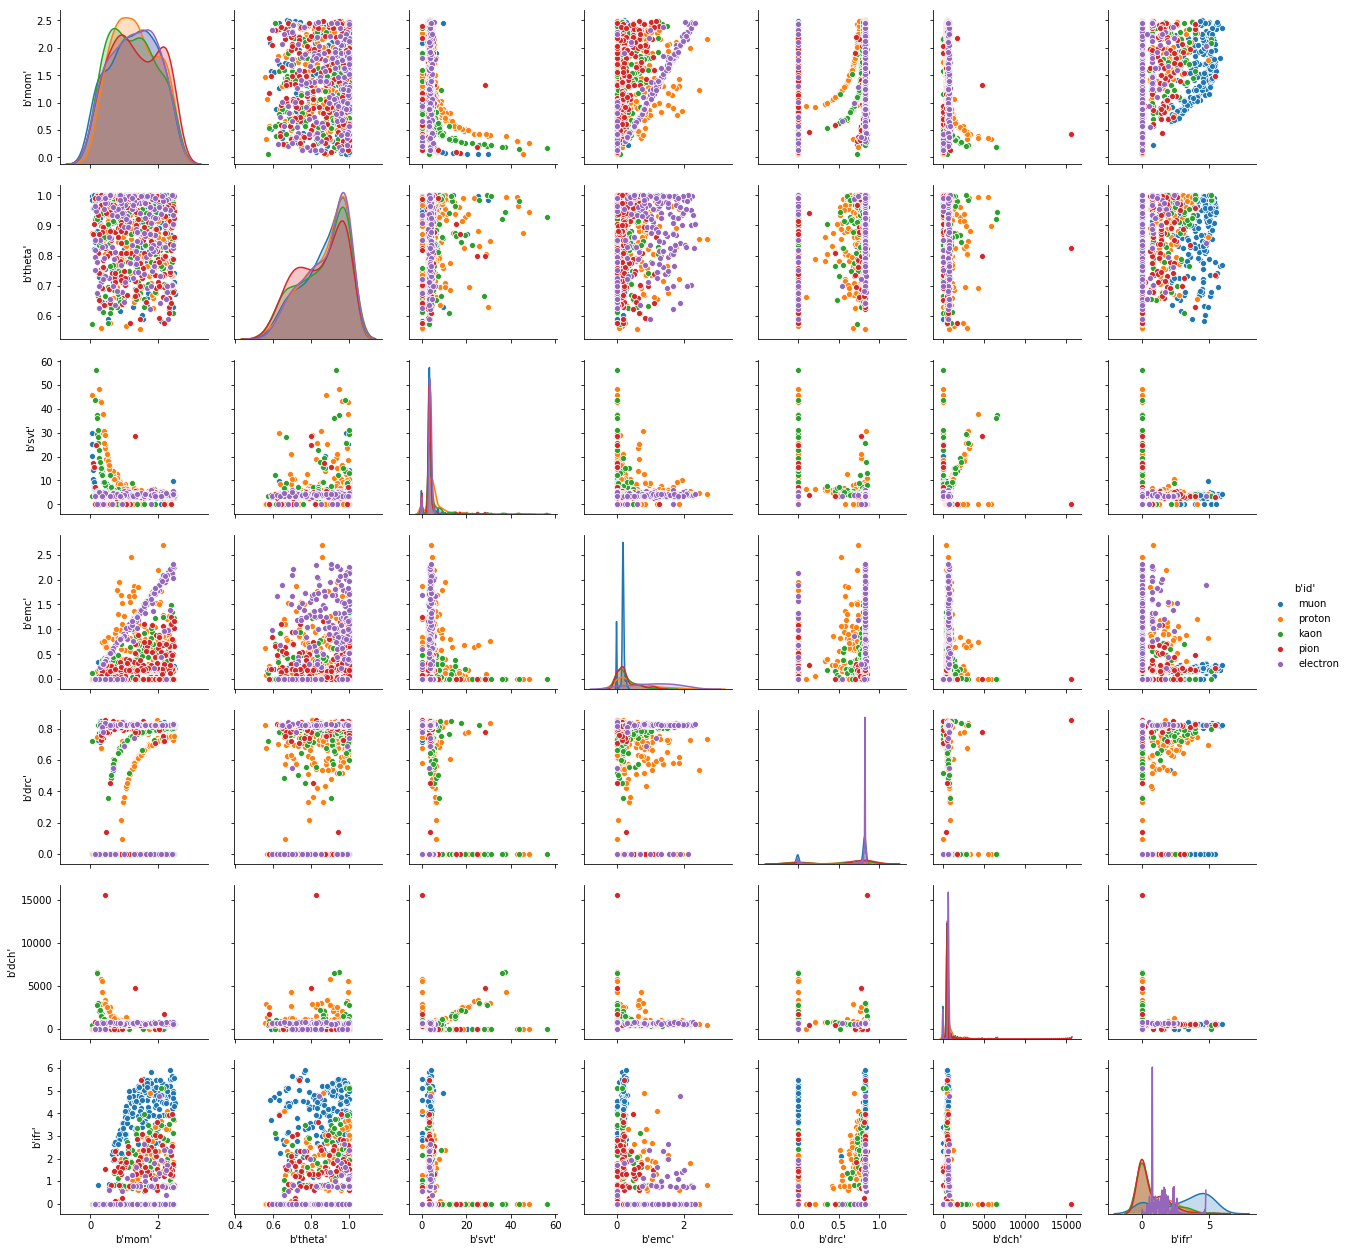

In [10]:
train = train_dataset[[b'mom', b'theta', b'svt', b'emc', b'drc', b'dch', b'ifr', b'id']]
train[b'id'] = train[b'id'].map( {0: 'electron', 1: 'muon', 2: 'pion', 3:'kaon', 4:'proton'} ).astype(str)
sns.pairplot(data=train[:1000], hue=b'id', diag_kind="kde")
plt.show()

We extract the particle labels to be used with supervised training:

In [11]:
train_labels = train_dataset.pop(b'id')
test_labels  = test_dataset.pop(b'id')

We normalize the training and test vectors:

In [12]:
train_stats = train_dataset.describe()
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
b'mom',75443.0,1.306043,0.688871,0.050066,0.720069,1.303027,1.899939,4.373626
b'theta',75443.0,0.868458,0.117722,0.540726,0.778496,0.900688,0.974906,1.000000
b'svt',75443.0,4.900804,5.308939,0.000000,3.320312,3.759766,4.492188,94.531250
b'emc',75443.0,0.436460,0.534734,0.000000,0.150585,0.203514,0.566483,3.915405
b'drc',75443.0,0.570131,0.351876,0.000000,0.000000,0.792004,0.820806,0.864134
b'dch',75443.0,605.947021,576.025208,0.000000,473.632812,537.109375,634.765625,17812.500000
b'ifr',75443.0,1.166395,1.620633,0.000000,0.000000,0.000000,2.039216,6.980392


In [13]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']

normed_train_data = norm(train_dataset)
normed_test_data  = norm(test_dataset)

## Building and Training the Model
The keras model implements a neural network with two hidden layers. The input feature vector represents measured detector quantities as defined above. The output reflects the particle probabilities.

In [14]:
def build_model():
    model = keras.Sequential([
    layers.Dense(25, activation=tf.nn.relu, input_shape=[len(train_dataset.keys())]),
    layers.Dense(10, activation=tf.nn.relu),
    keras.layers.Dense(5, activation=tf.nn.softmax)
  ])

    model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
    return model

In [15]:
model = build_model()

Instructions for updating:
Colocations handled automatically by placer.


In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 25)                200       
_________________________________________________________________
dense_1 (Dense)              (None, 10)                260       
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 55        
Total params: 515
Trainable params: 515
Non-trainable params: 0
_________________________________________________________________


Use 10% of the training data for validation. Display the training progress by printing a single dot for each completed epoch:

In [17]:
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

EPOCHS = 10

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.1, verbose=0,
  callbacks=[PrintDot()])


..........

## Training History
We produce some control plots from the Keras history. 

In [18]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

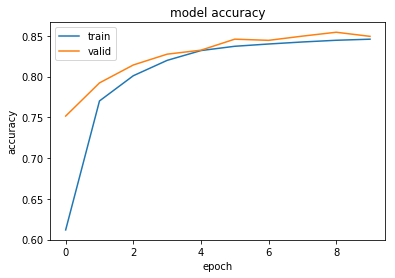

In [19]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

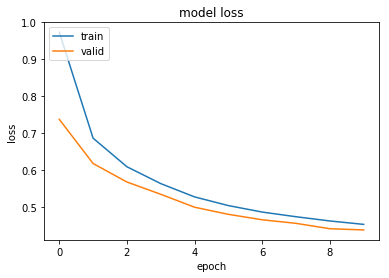

In [20]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

## Model Evaluation
We evaluate the model performance presenting the yet unused normalized test data set and compare the output vector to the test labels. The output vector holds the probabilities of the five particle hypotheses.

In [21]:
test_loss, test_acc = model.evaluate(normed_test_data, test_labels)

8383/8383 [==============================] - 0s 12us/sample - loss: 0.4551 - acc: 0.8436


In [22]:
predictions = model.predict(normed_test_data)
predictions

array([[9.9999380e-01, 1.0788713e-12, 2.3103187e-06, 1.4063195e-08,
        3.9833430e-06],
       [8.6237216e-01, 1.0606706e-02, 5.1864687e-02, 7.4740902e-02,
        4.1549827e-04],
       [9.9943441e-01, 4.5445313e-07, 2.0366479e-04, 7.0754279e-05,
        2.9069959e-04],
       ...,
       [3.3943288e-06, 6.1312693e-07, 4.3096021e-05, 7.1124472e-02,
        9.2882842e-01],
       [8.1577573e-06, 7.4853423e-10, 2.1717680e-05, 2.0193456e-02,
        9.7977668e-01],
       [2.6829777e-10, 1.4748071e-10, 4.9351142e-06, 7.5388215e-02,
        9.2460680e-01]], dtype=float32)

The confusion matrix indicates that the separation strength of the network is rather good. However, it seems that the separation of muons from pions is difficult (2nd/3rd row/colum).

In [23]:
pred_labels = np.argmax(predictions, axis=1)
print(confusion_matrix(test_labels, pred_labels))

[[1457   11   47   23   50]
 [  80 1402  350   25    5]
 [  66  135 1339  141   43]
 [  16   14   66 1388   80]
 [  20   15   48   76 1486]]


Generate a summary report:

In [24]:
print(classification_report(test_labels, pred_labels, target_names=target_names))

              precision    recall  f1-score   support

    Electron       0.89      0.92      0.90      1588
        Muon       0.89      0.75      0.82      1862
        Pion       0.72      0.78      0.75      1724
        Kaon       0.84      0.89      0.86      1564
      Proton       0.89      0.90      0.90      1645

   micro avg       0.84      0.84      0.84      8383
   macro avg       0.85      0.85      0.85      8383
weighted avg       0.85      0.84      0.84      8383



## Physics Control Plots

We inspect the results by plotting the measured data in dependence of the particle momentum. The color index is: protons (yellow), kaons (green), pions (cyan), muons (blue), electrons (red). The left plot corresponds to the true labels, the right plot corresponds to the predicted labels, respectively.

In [25]:
mom = test_dataset[b'mom']
svt = test_dataset[b'svt']
emc = test_dataset[b'emc']
dch = test_dataset[b'dch']
drc = test_dataset[b'drc']
ifr = test_dataset[b'ifr']

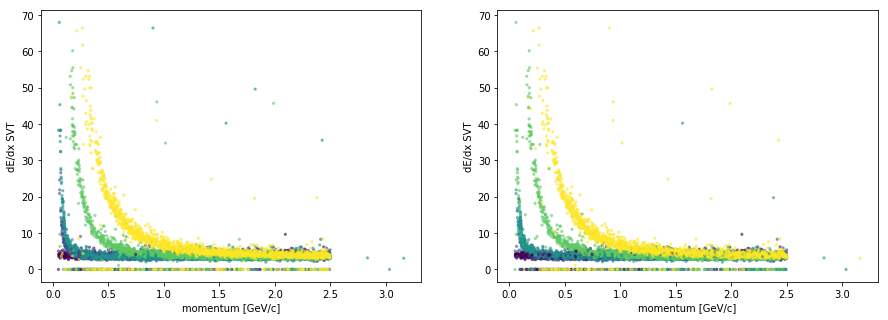

In [26]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(mom, svt, alpha=0.5,
            s=5, c=test_labels, cmap='viridis')
plt.ylabel('dE/dx SVT')
plt.xlabel('momentum [GeV/c]')
plt.subplot(1,2,2)
plt.scatter(mom, svt, alpha=0.5,
            s=5, c=pred_labels, cmap='viridis')
plt.ylabel('dE/dx SVT')
plt.xlabel('momentum [GeV/c]')
plt.show()

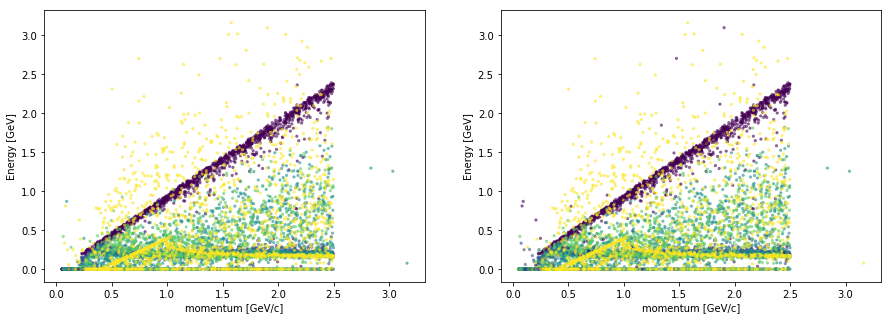

In [27]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(mom, emc, alpha=0.5,
            s=5, c=test_labels, cmap='viridis')
plt.ylabel('Energy [GeV]')
plt.xlabel('momentum [GeV/c]')
plt.subplot(1,2,2)
plt.scatter(mom, emc, alpha=0.5,
            s=5, c=pred_labels, cmap='viridis')
plt.ylabel('Energy [GeV]')
plt.xlabel('momentum [GeV/c]')
plt.show()

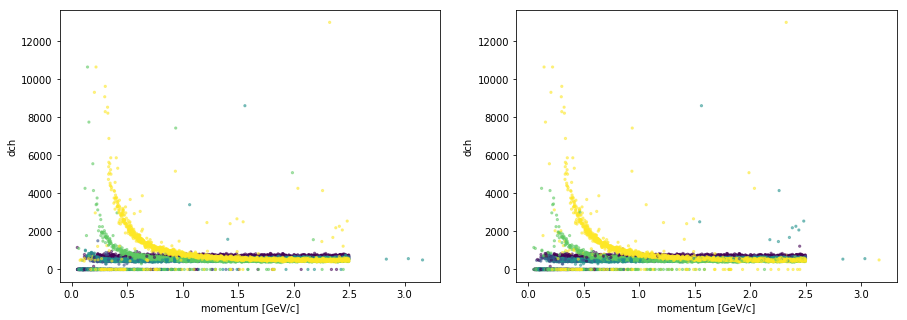

In [28]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(mom, dch, alpha=0.5,
            s=5, c=test_labels, cmap='viridis')
plt.ylabel('dch')
plt.xlabel('momentum [GeV/c]')
plt.subplot(1,2,2)
plt.scatter(mom, dch, alpha=0.5,
            s=5, c=pred_labels, cmap='viridis')
plt.ylabel('dch')
plt.xlabel('momentum [GeV/c]')
plt.show()

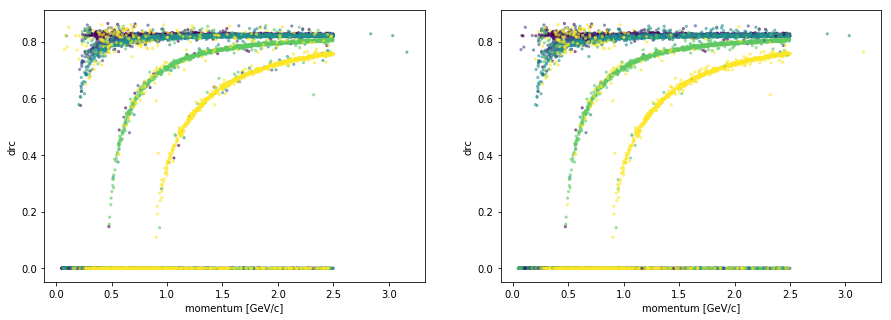

In [29]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(mom, drc, alpha=0.5,
            s=5, c=test_labels, cmap='viridis')
plt.ylabel('drc')
plt.xlabel('momentum [GeV/c]')
plt.subplot(1,2,2)
plt.scatter(mom, drc, alpha=0.5,
            s=5, c=pred_labels, cmap='viridis')
plt.ylabel('drc')
plt.xlabel('momentum [GeV/c]')
plt.show()

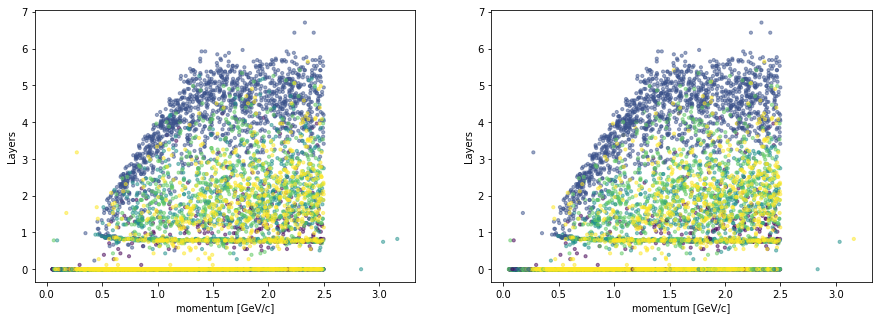

In [30]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(mom, ifr, alpha=0.5,
            s=10, c=test_labels, cmap='viridis')
plt.ylabel('Layers')
plt.xlabel('momentum [GeV/c]')
plt.subplot(1,2,2)
plt.scatter(mom, ifr, alpha=0.5,
            s=10, c=pred_labels, cmap='viridis')
plt.ylabel('Layers')
plt.xlabel('momentum [GeV/c]')
plt.show()

## Muon Selection
By inspection of the physics control plots it seems difficult to clearly separate muons (blue) from pions (cyan) by simple linear cuts. Thus we want to construct a muon selector based on the network output (the five particle probabilities). Taking into account the relative a priori probabilities of the particle occurence we can formulate a log likelihood ratio to observe a muon (Pions are 5 times more abundant than muons, protons occur at 10% only).

In [31]:
electron = predictions[:,0]
muon     = predictions[:,1]
pion     = predictions[:,2] * 5.0
kaon     = predictions[:,3]
proton   = predictions[:,4] * 0.1

In [32]:
L = np.log(muon) - np.log(pion)

If we plot L = log(muon) - log(pion) we are able to clearly separate muons by a cut on L > -0.8 over a wide momentum range.

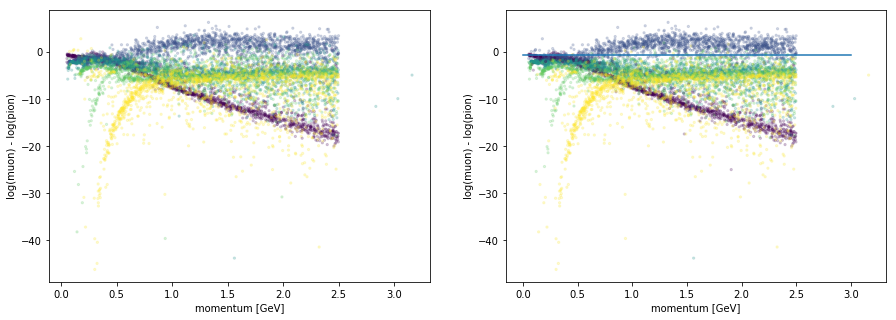

In [33]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.scatter(mom, L, alpha=0.2,
            s=5, c=test_labels, cmap='viridis')
plt.ylabel('log(muon) - log(pion)')
plt.xlabel('momentum [GeV]')
plt.subplot(1,2,2)
plt.scatter(mom, L, alpha=0.2,
            s=5, c=pred_labels, cmap='viridis')
cut = -0.8 
plt.plot(np.repeat(cut,4))
plt.Line2D([0.,3.],[-25.,-25.],lw=10,ls='-')
plt.ylabel('log(muon) - log(pion)')
plt.xlabel('momentum [GeV]')
plt.show()